<a href="https://colab.research.google.com/github/fyemane/TensorFlow-ZTM-/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problems.

There are two main benefits:
* Can leverage an existing neural network architecture proven to work on problems similar to our own.
* Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [ ]:
# Are we using  GPU
!nvidia-smi

Sun Jun 11 19:15:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and preparing data for our first transfer learning model


In [ ]:
# Get data (10% of 10 food classes from Food101)
# https://www.kaggle.com/datasets/dansbecker/food-101
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-06-11 19:15:19--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 172.253.118.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  23.6MB/s    in 8.0s    

2023-06-11 19:15:27 (20.1 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"Ther are {len(dirnames)} directories and {len(filenames)} images in `{dirpath}`.")

Ther are 2 directories and 0 images in `10_food_classes_10_percent`.
Ther are 10 directories and 0 images in `10_food_classes_10_percent/test`.
Ther are 0 directories and 250 images in `10_food_classes_10_percent/test/hamburger`.
Ther are 0 directories and 250 images in `10_food_classes_10_percent/test/ramen`.
Ther are 0 directories and 250 images in `10_food_classes_10_percent/test/sushi`.
Ther are 0 directories and 250 images in `10_food_classes_10_percent/test/ice_cream`.
Ther are 0 directories and 250 images in `10_food_classes_10_percent/test/steak`.
Ther are 0 directories and 250 images in `10_food_classes_10_percent/test/chicken_curry`.
Ther are 0 directories and 250 images in `10_food_classes_10_percent/test/fried_rice`.
Ther are 0 directories and 250 images in `10_food_classes_10_percent/test/grilled_salmon`.
Ther are 0 directories and 250 images in `10_food_classes_10_percent/test/pizza`.
Ther are 0 directories and 250 images in `10_food_classes_10_percent/test/chicken_wings`

### Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches.

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")
print("Test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")


Training images:
Found 750 images belonging to 10 classes.
Test images:
Found 2500 images belonging to 10 classes.


## Introducing Callbacks in TensorFlow and making a callback to track our models

Setting up callbacks (things to run whilst our model trains).

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:
* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback
* Others in https://www.tensorflow.org/api_docs/python/tf/keras/callbacks

In [ ]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
# use time stamp when model was run
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
  # create directory path of whether to store logged model
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y-%m-%d--%H:%M:%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Exploring the TensorFlow Hub website for pretrained models

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

Models that work good with image domain: ResNet V2 50, EfficientNet-80

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model:
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1


## Building and compiling a TensorFlow Hub feature extraction model


In [ ]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Let's make a create_model() function to create a model from a url
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_layer", # freeze the already learned patterns
                                           input_shape=IMAGE_SHAPE+(3, )) # from (224, 224) to (224, 224, 3)
  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [ ]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [ ]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

## Blowing our previous models out of the water with transfer learning

In [ ]:
# Let's fit our ResNet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/2023-06-11--19:15:46
Epoch 1/5
24/24 [==============================] - 37s 974ms/step - loss: 1.8741 - accuracy: 0.3573 - val_loss: 1.1756 - val_accuracy: 0.6276
Epoch 2/5
24/24 [==============================] - 22s 938ms/step - loss: 0.8822 - accuracy: 0.7333 - val_loss: 0.8501 - val_accuracy: 0.7232
Epoch 3/5
24/24 [==============================] - 20s 877ms/step - loss: 0.6021 - accuracy: 0.8360 - val_loss: 0.7352 - val_accuracy: 0.7636
Epoch 4/5
24/24 [==============================] - 21s 911ms/step - loss: 0.4621 - accuracy: 0.8827 - val_loss: 0.6900 - val_accuracy: 0.7820
Epoch 5/5
24/24 [==============================] - 18s 769ms/step - loss: 0.3760 - accuracy: 0.9107 - val_loss: 0.6672 - val_accuracy: 0.7788


Wow!

That is incredible. Our transfer learning feature extractor model outperformed ALL of the previous models we built by hand... (substantially) and in a quicker training time AND with only 10% of the training examples.

## Plotting the loss curves of our ResNet feature extraction model


In [ ]:
# Let's create a function to plot our loss curves
# Tidbit: you could put a function liek this into a script called "helper.py" and import it when you need it.
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs=range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

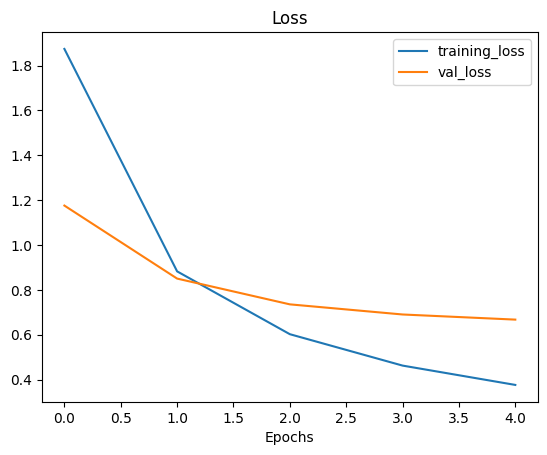

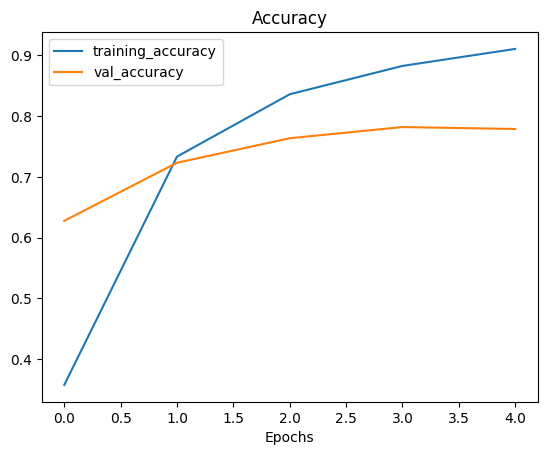

In [ ]:
plot_loss_curves(resnet_history)

## Building and training a pre-trained EfficientNet model on our data

In [ ]:
# Create EfficientNetB0 feature extractor model
# https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

# Fit EfficientNet model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/2023-06-11--19:18:45
Epoch 1/5
24/24 [==============================] - 60s 2s/step - loss: 1.9237 - accuracy: 0.3880 - val_loss: 1.3480 - val_accuracy: 0.7092
Epoch 2/5
24/24 [==============================] - 19s 825ms/step - loss: 1.0933 - accuracy: 0.7627 - val_loss: 0.8909 - val_accuracy: 0.8164
Epoch 3/5
24/24 [==============================] - 20s 854ms/step - loss: 0.7739 - accuracy: 0.8320 - val_loss: 0.7082 - val_accuracy: 0.8448
Epoch 4/5
24/24 [==============================] - 18s 774ms/step - loss: 0.6202 - accuracy: 0.8533 - val_loss: 0.6165 - val_accuracy: 0.8596
Epoch 5/5
24/24 [==============================] - 18s 783ms/step - loss: 0.5222 - accuracy: 0.8813 - val_loss: 0.5651 - val_accuracy: 0.8640


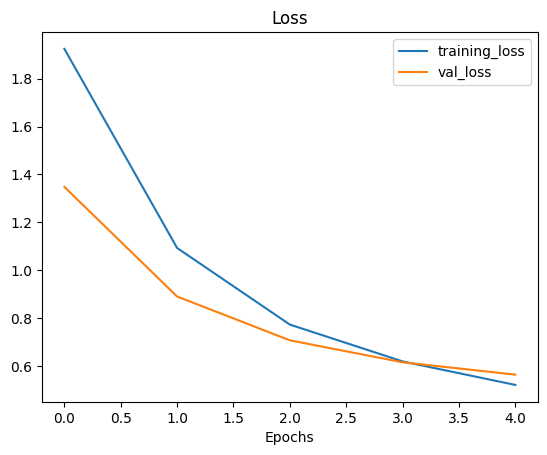

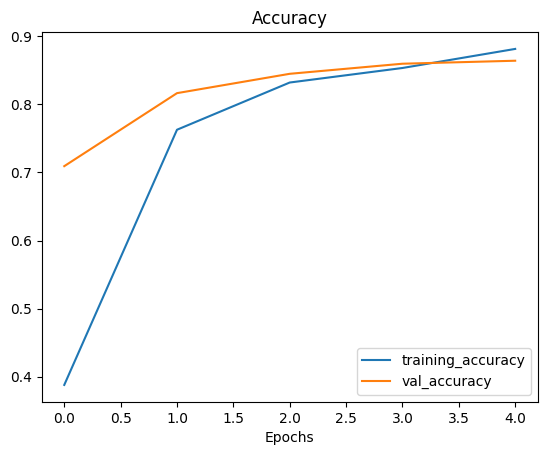

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


## Different types of Transfer Learning

* **"As is" transfer learning** - using an existing model with no changes whatsoever (e.g. Using ImageNet model on 1000 ImageNet classes, none of your own)
* **"Feature extraction"** transfer learning - using the prelearned patterns of an existing model (e.g. EfficientNetb0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food)
* **"Fine-tuning"** transfer learning - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

In [ ]:
# How many layers does our efficientnetb0 feature extractor have?
len(efficientnet_model.layers[0].weights)

309

## Comparing Our Models' Results using TensorBoard

> **Note:** When you upload things to [TensorBoard.dev](https://tensorboard.dev/), your experiments are public. So if you're running private experiments (things you don't want others to see), do not upload them to TensorBoard.dev.

In [ ]:
# Upload TensorBoard.dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
--name "EfficientNetB0 vs. ResNet50V2" \
--description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
--one_shot

2023-06-11 19:43:22.712311: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) no


Our TensorBoard experiments are uploaded publicly here:

In [ ]:
# Load tensorboard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Start TensorBoard within the notebook using magics
# https://ipython.readthedocs.io/en/stable/interactive/magics.html
%tensorboard --logdir tensorflow_hub --port 6007

In [ ]:
# Checkout out TensorBoard experiments you have
!tensorboard dev list

2023-06-11 20:11:00.918737: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will list all experiments that you've uploaded to
https://tensorboard.dev. TensorBoard.dev experiments are visible
to everyone. Do not upload sensitive data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) no


In [ ]:
# Delete an experiment
# !tensorboard dev delete --experiment_id

In [ ]:
# Confirm the deletion by re-checking what experiments you have left